# Implementation of models of neurons

## First model of a neuron - (1)

- Hodgkin-Huxley model
- describing a pyramidal cell
- single-compartment

WARNING    The NeuronGroup 'neuron' sets a threshold but neither a reset condition nor a refractory condition has been set. Did you forget either of those? If this was intended, set the reset argument to an empty string in order to avoid this warning. [brian2.groups.neurongroup.only_threshold]
WARNING    Cannot use Cython, a test compilation failed: Cython is not available (ImportError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Starting simulation at t=0. s for a duration of 0.5 s
176.28 ms (35%) simulated in 10s, estimated 18s remaining.
0.34712 s (69%) simulated in 20s, estimated 9s remaining.
0.5 s (100%) simulated in 28s


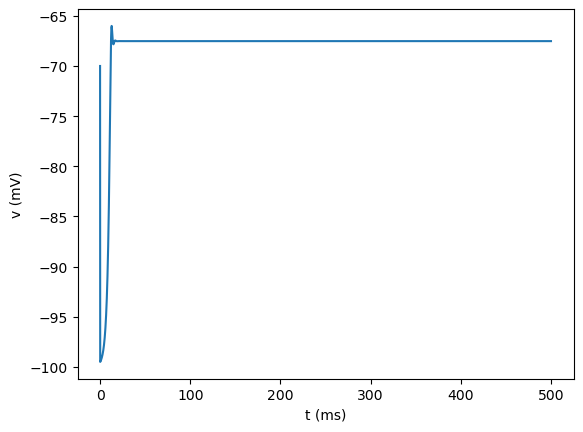

In [1]:
from brian2 import *

defaultclock.dt = 0.01*ms

codegen.target='cython'

start_scope()

Texp = 37; C = 1*uF/cm**2 
El = -87*mV; ENa = 71*mV; EK = -100*mV
gl = 33.8*usiemens/cm**2; gK = 6930000*usiemens/cm**2; gNa = 2040000*usiemens/cm**2
Um = -38*mV; Wm = 6*mV; Uh = -66*mV; Wh = 6*mV
Un = 18.7*mV; Wn = 9.7*mV
Q10 = 2.3

eqs = '''
Iin : ampere/metre**2
minf = alpham/(alpham+betam) : 1
hinf = alphah/(alphah+betah) : 1
ninf = 1/(1 + exp((Un - v)/Wn)) : 1
Taum = 1/(Tau*(alpham + betam)) : second
Tauh = 1/(Tau*(alphah + betah)) : second
Taun = 0.004*second/((Tau * (1/exp(-(v+56.56*mV)/(44.14*mV))))) : second
Tau = Q10**((Texp-21)/10) : 1
alpham = (182/mvolt/second*(v - Um))/(1 - exp((Um-v)/Wm)) : Hz
betam = (124/mvolt/second*(Um-v))/(1 - exp((v-Um)/Wm)) : Hz
alphah = (15/mvolt/second*(Uh - v))/(1 - exp((v - Um)/Wh)) : Hz
betah = (15/mvolt/second*(v - Uh))/(1 - exp((Uh - v)/Wh)) : Hz
dv/dt =  (Iin -gl*(v - El) - gNa*m**3*h*(v - ENa) - gK*n*(v - EK)) / C : volt
dm/dt = (minf-m)/Taum : 1
dh/dt = (hinf-h)/Tauh : 1
dn/dt = (ninf-n)/Taun : 1
'''

neurons = NeuronGroup(1, eqs, threshold='v > 50*mV', method='exponential_euler',name='neuron*',dt=0.02*ms)
neurons.v = -70*mV
neurons.m = 0.01 
neurons.h = 0.99
neurons.n = 0.01
neurons.Iin = 10**4.5*nA/cm**2

NeuMonitor = StateMonitor(neurons, variables = ["v", "m", "h", "n"],record=True,name='neumon*')
run(0.5 * second, report='text')

plot(NeuMonitor.t/ms, NeuMonitor.v[:].T/mV)
# plot(NeuMonitor.t/ms, NeuMonitor[10].v/mV)
# plot(NeuMonitor.t/ms, NeuMonitor[99].v/mV)
xlabel('t (ms)')
ylabel('v (mV)')
show()


#neurons.Q10 = 37*kelvin
# S = SpikeMonitor(neurons)

# store() 

# We locate the threshold by bisection
# v0 = 25*mV*ones(len(neurons))
# step = 25*mV

# for i in range(10): 
#     restore()
#     neurons.v = v0 
#     run(20*ms)
#     v0[S.count == 0] += step 
#     v0[S.count >0]-=step 
#     step /= 2.0

## Neuronal Model Code (structured) - (2)

- Hodgkin-Huxley model
- describing a pyramidal cell
- single-compartment

In [5]:
device.reinit()
device.activate()

#-----------------------------------------------------------------------------------------------------------------------
# Default Imports
#-----------------------------------------------------------------------------------------------------------------------
import numpy as np
import scipy.constants as spc

#-----------------------------------------------------------------------------------------------------------------------
# Brian2 import: we use Brian CPP-standalone code generation for fast parallelized simulations
#-----------------------------------------------------------------------------------------------------------------------
from brian2 import *
code_dir = './codegen'
prefs.GSL.directory = '/opt/anaconda3/envs/Brian2_NGILab/include/'   ## The directory where the GSL library headings are found
set_device('cpp_standalone',directory=code_dir,build_on_run=False)
prefs.devices.cxpp_standalone.openmp_threads = 8 ## The number of threads used in the parallelization (machine-dependent)
prefs.logging.file_log = False
prefs.logging.delete_log_on_exit = True

import matplotlib.pyplot as plt

#-----------------------------------------------------------------------------------------------------------------------
## Utilities
#-----------------------------------------------------------------------------------------------------------------------
def varargin(pars, **kwargs):
    """
    varargin-like option for user-defined parameters in any function/module
    Use:
    pars = varargin(pars,**kwargs)

    Input:
    - pars     : the dictionary of parameters of the calling function
    - **kwargs : a dictionary of user-defined parameters

    Output:
    - pars     : modified dictionary of parameters to be used inside the calling
                 (parent) function

    Maurizio De Pitta', The University of Chicago, August 27th, 2014.
    """
    for key, val in kwargs.items():
        if key in pars:
            pars[key] = val
    return pars

#-----------------------------------------------------------------------------------------------------------------------
## Build User-defined convenience functions to be also called by equations in neuron models by Brian
#-----------------------------------------------------------------------------------------------------------------------
def Hill(x,K,n):
    return x**n/(x**n+K**n)
Hill = Function(Hill,arg_units=[mmolar,mmolar,1], return_unit=1,auto_vectorise=False)
Hill_cpp = '''
    #include <math.h>
    double Hill(double x,double K,double n)
    {
        return pow(x,n)/(pow(x,n)+pow(K,n));
    };
    '''
Hill.implementations.add_implementation('cpp',Hill_cpp,compiler_kwds={'headers': ['"math.h"']})

def ThermalVoltage(T):
    return spc.R*(T+273.15)/spc.physical_constants['Faraday constant'][0]
ThermalPotential = Function(ThermalVoltage,arg_units=[1], return_unit=1,auto_vectorise=False)
ThermalVoltage_cpp = '''
    #include <gsl/gsl_const_mksa.h>
    double ThermalPotential(const double T)
    {
        const double R = GSL_CONST_MKSA_MOLAR_GAS;
        const double F = GSL_CONST_MKSA_FARADAY;
        return R*(T+273.15)/F;
    }
    '''
ThermalPotential.implementations.add_implementation('cpp',ThermalVoltage_cpp,
                                                  compiler_kwds={'headers': ['"gsl_const_mksa.h"'],
                                                                 'include_dirs': ['/opt/anaconda3/envs/Brian2_NGILab/include/']})
def NernstPotential(x_e,x_i,z,T):
    """
    Nernst potential in volts (w/out units)

    Input parameters (w/out units):
    - x_e : float   Intracellular concentration
    - x_i : float   Extracellyular concentration
    - z   : int     Ion valence
    - T   : float   Temperature in ^C

    Return:
    - E_x : Nernst Reverse Potential in volt (W/OUT units)
    """
    V_T = ThermalVoltage(T)
    return V_T/z*np.log(x_e/x_i)
NernstPotential = Function(NernstPotential,arg_units=[mmolar,mmolar,1,1], return_unit=1,auto_vectorise=False)
NernstPotential_cpp = '''
    #include <gsl/gsl_const_mksa.h>
    const double R = GSL_CONST_MKSA_MOLAR_GAS; 
    const double F = GSL_CONST_MKSA_FARADAY;
    double ThermalVoltage(const double T)
    {
        return R*(T+273.15)/F;
    };
    double NernstPotential(double x_e,double x_i,double z,const double T)
    {
        return ThermalVoltage(T)*log(x_e/x_i)/z;
    };
    '''
NernstPotential.implementations.add_implementation('cpp',NernstPotential_cpp,
                                                   dependencies={'log': DEFAULT_FUNCTIONS['log']},
                                                   compiler_kwds={'headers': ['"gsl_const_mksa.h"'],
                                                                  'include_dirs': ['/opt/anaconda3/envs/Brian2_NGILab/include/']})


def Heaviside_Function(t_step, t_end, t):
    if (t < t_step):
        return 0
    elif (t_step <= t <= t_end):
        return 1
    else:
        return 0
Heaviside_Function = Function(Heaviside_Function,arg_units=[second,second,second], return_unit=1,auto_vectorise=False)
Heaviside_Function_cpp = '''
    double Heaviside_Function(double t_step, double t_end, double t)
    {
    if (t < t_step)
        return 0;
    else if (t <= t_end)
        return 1;
    else
        return 0;
    };
    '''
Heaviside_Function.implementations.add_implementation('cpp',Heaviside_Function_cpp,
                                                   dependencies={'log': DEFAULT_FUNCTIONS['log']},
                                                    )

def lpc5_parameters(model='hh-neuron',**kwargs):
    """
    Method to generate neuron parameters' dictionary.

    Input parameters:
    - model  : {'hh-neuron'} (or 'hh') | 'hh-ecs'   Model equations
    **kwargs : list of custom parameters specified by <parameter name>=<value in units>

    Return:
    - pars   : dict
    """

    ta = TimedArray([0, 1] * 1, dt=0.1*second)

    # Define dictionary of default parameters values
    pars = {## Concentrations to setup reverse potentials
            'N0_i': 10*mmolar,
            'N0_e': 145*mmolar,
            'K0_i': 130*mmolar,
            'K0_e': 3*mmolar,
            'C0_i': 5*mmolar,
            'C0_e': 130*mmolar,
            ## Neuron Parameters and conductances
            'c_m' : 1*ufarad/cm**2,
            'g_Na': 2.04e6*usiemens/cm**2,
            'g_K' : 0.638e6*usiemens/cm**2,
            'g_Cl': 0.338e3*usiemens/cm**2,
            'v_thr' : 0*mvolt,
            ## Gating variables
            'U_m' : -38*mvolt,
            'U_h' : -66*mvolt,
            'U_n' : 18.7*mvolt,
            'W_m' : 6*mvolt,
            'W_h' : 6*mvolt,
            'W_n' : 9.7*mvolt,
            ## Temperature
            'T_exp' : 37, ## Body temperature of the animal
            ## External Stimulation
            'I_dc'  : 0*namp/cm**2,
            'I_ramp': 0*namp/cm**2,
            'I_max' : 42000*namp/cm**2,
            'T_ramp': 100*second,
            'TimedArray': ta,
            ## times
            't_step': 0.05 * second,
            't_end' : 0.1 * second,
            }

    pars = varargin(pars,**kwargs)

    # We define this quantities after any user-defined parameters are specified
    pars['T_adj'] = 2.3**(0.1*(pars['T_exp']-21))
    pars['E_Na'] = NernstPotential(pars['N0_e'],pars['N0_i'],1,pars['T_exp'])*volt
    pars['E_K']  = NernstPotential(pars['K0_e'],pars['K0_i'],1,pars['T_exp'])*volt
    pars['E_Cl'] = NernstPotential(pars['C0_e'],pars['C0_i'],-1,pars['T_exp'])*volt

    ## Physics constants
    pars['F'] = spc.physical_constants['Faraday constant'][0]*coulomb/mole

    return pars

def lpc5_neuron(N,params,model='hh-neuron',name='hh*',dt=None):
    """
    Method that generate the "neuron" model with given parameters.

    Input aarguments:
    - N      : int      Number of neurons to simulate
    - params : dict     Dictionary of neuron parameters
    - model  : {'hh-neuron'} | 'hh-ecs'  Model equations
    - name   : String   The name assigned to the NeuronGroup
    - dt     : float*second minimum time step for numerical integration

    Return:
    - neuron : NeuronGroup
    """
    # I_inj=I_dc+I_ramp*t/T_ramp                      : amp/meter**2
    # I_inj= 2*I_max-(I_max*exp((t-(0.15*second))**2/(2*0.003*(second**2))))                     : amp/meter**2

    eqs = Equations('''
    a_m=-0.182/second/mvolt*(v-U_m)/expm1((U_m-v)/W_m)   : hertz
    b_m=-0.124/second/mvolt*(U_m-v)/expm1((v-U_m)/W_m)   : hertz
    a_h=-0.015/second/mvolt*(U_h-v)/expm1((v-U_h)/W_h)   : hertz
    b_h=-0.015/second/mvolt*(v-U_h)/expm1((U_h-v)/W_h)   : hertz
    m_inf=a_m/(a_m+b_m)                                : 1
    h_inf=a_h/(a_h+b_h)                                : 1
    n_inf=1/(1+exp(-(v-U_n)/W_n))                      : 1
    tau_m=1e-3/(a_m+b_m)/T_adj                         : second
    tau_h=1e-3/(a_h+b_h)/T_adj                         : second
    tau_n=4*ms/(1+exp(-(v+56.56*mvolt)/(44.14*mvolt)))/T_adj      : second
    I_inj=I_max * TimedArray(t)                    : amp/meter**2
    dm/dt=(m_inf-m)/tau_m                           : 1
    dh/dt=(h_inf-h)/tau_h                           : 1
    dn/dt=(n_inf-n)/tau_n                           : 1
    ''')

    if model=='hh-neuron':
        eqs += Equations('''
            I_Na=g_Na*m**3*h*(v-E_Na)                       : amp/meter**2
            I_K=g_K*n*(v-E_K)                               : amp/meter**2
            I_Cl=g_Cl*(v-E_Cl)                              : amp/meter**2
            dv/dt=(I_inj-I_Na-I_K-I_Cl)/c_m                 : volt   
        ''')
    else:
        ## w/ ECS
        pass

    neuron = NeuronGroup(N,eqs,
                         threshold='v>v_thr',
                         namespace=params,
                         name=name,
                         method='rk4',
                         dt=dt)

    # Initialize gating variables
    neuron.m = 0.01
    neuron.h = 0.99
    neuron.n = 0.01

    return neuron

def lpc5_simulation(duration=0.2,model='hh-neuron',**kwargs):
    """
    This is the actual simulation of the Neuron. It is provided as a standalone method for modularity.

    Input parameters:
    - duration   : float*second   Simulated Time
    - model      : {'hh-neuron'} | 'hh-ecs'   Use only 'hh-neuron' for now. Other cases will be added later.
    :param kwargs:
    :return:
    """

    device.delete(force=True)
    ## Build the neuron model and monitors
    params = lpc5_parameters(model=model,T_ramp=duration*second,**kwargs)

    # Initialize model
    cell = lpc5_neuron(1,params,model=model,name='HH',dt=0.1*us)
    cell.v = NernstPotential(params['C0_e'],params['C0_i'],-1,params['T_exp'])*volt

    # Set monitors
    if model=='hh-neuron':
        variables = ['v']
    elif model=='hh-ecs':
        variables = ['v','C_i','N_i','K_i','I_K','I_Na','I_Cl','n_Cl','n_K','E_Cl']
    sv_mon = StateMonitor(cell,variables=variables,record=True,dt=0.01*ms,name='svmon')
    # Gene
    network = Network([cell,sv_mon])
    ## Run the simulator
    network.run(duration=duration*second,report='text')
    device.build(directory=code_dir, clean=True)

    ## Visualizing data
    if model=='hh-neuron':
        fig, ax = plt.subplots(1, 1)
        ax.plot(sv_mon.t, sv_mon.v[:].T, 'k-')
    elif model=='hh-ecs':
        fig, ax = plt.subplots(6, 1,sharex=True)
        ax[0].plot(sv_mon.t, sv_mon.v[:].T, 'k-')
        ax[0].plot(sv_mon.t, sv_mon.E_Cl[:].T, 'm-')
        # ax[1].plot(sv_mon.t, sv_mon.C_i[:].T, 'm-')
        # ax[1].plot(sv_mon.t, sv_mon.C_i[:].T, 'r-')
        # ax[1].plot(sv_mon.t, sv_mon.N_i[:].T, 'r-')
        # ax[1].plot(sv_mon.t,sv_mon.I_Na[:].T,'r-')
        # ax[2].plot(sv_mon.t,sv_mon.I_K[:].T,'b-')
        # ax[3].plot(sv_mon.t,sv_mon.I_Cl[:].T,'g-')
        # ax[4].plot(sv_mon.t,sv_mon.I_NKP[:].T,'y-')
        # ax[5].plot(sv_mon.t,sv_mon.I_KCC[:].T,'m-')
        ax[1].plot(sv_mon.t, sv_mon.n_Cl[:].T, 'm-')
        ax[1].hlines(0,*sv_mon.t[[0,-1]])
        ax[2].plot(sv_mon.t, sv_mon.I_Cl[:].T, 'r-')
        ax[3].plot(sv_mon.t, sv_mon.n_K[:].T, 'g-')

    device.delete(force=True)

if __name__=="__main__":
    """
    Uncomment individual sections to test different methods 
    """

    # #-------------------------------------------------------------------------------------------------------------------
    # # Verify Reverse Potentials
    # #-------------------------------------------------------------------------------------------------------------------
    # T= 37
    # print('E_Na\t',NernstPotential(126,9,1,T))
    # print('E_K\t',NernstPotential(2.5,130,1,T))
    # print('E_Cl\t',NernstPotential(130,10,-1,T))

    # #-------------------------------------------------------------------------------------------------------------------
    # # Generate Neuron Simulation
    # #-------------------------------------------------------------------------------------------------------------------
    print(lpc5_parameters('hh-neuron',I_dc=10**4.5*nA/cm**2))
    # Single Neuron
    lpc5_simulation(duration=0.2,model='hh-neuron',I_dc=10**4.2*nA/cm**2)

    # #-------------------------------------------------------------------------------------------------------------------
    ## Show figures
    # #-------------------------------------------------------------------------------------------------------------------
    plt.show()

KeyError: 'devices.cxpp_standalone'

## Implementation of Neuronal Ionostasis in (2) - (3)


In [47]:
device.reinit()
device.activate()

#-----------------------------------------------------------------------------------------------------------------------
# Default Imports
#-----------------------------------------------------------------------------------------------------------------------
import numpy as np
import math
import scipy.constants as spc
import importlib

#-----------------------------------------------------------------------------------------------------------------------
# Brian2 import: we use Brian CPP-standalone code generation for fast parallelized simulations
#-----------------------------------------------------------------------------------------------------------------------
from brian2 import *
code_dir = './codegen'
prefs.GSL.directory = '/opt/anaconda3/envs/Brian2_NGILab/include/'   ## The directory where the GSL library headings are found
set_device('cpp_standalone',directory=code_dir,build_on_run=False)
prefs.devices.cpp_standalone.openmp_threads = 1 ## The number of threads used in the parallelization (machine-dependent)
prefs.logging.file_log = False
prefs.logging.delete_log_on_exit = True

%matplotlib widget
import matplotlib.pyplot as plt
import Equations_calc
import parameters
importlib.reload(Equations_calc)
importlib.reload(parameters)
from Equations_calc import calculate_gating_variable_n, calculate_gating_variable_h, calculate_gating_variable_m, return_HH_equations, return_plotting_list
from Equations import calc_leakage_conductance, I_Na_inf, f_NaK, sigma, calculate_I_NKP_max
from parameters import return_initial_parameters


#-----------------------------------------------------------------------------------------------------------------------
## Utilities
#-----------------------------------------------------------------------------------------------------------------------
def varargin(pars, **kwargs):
    """
    varargin-like option for user-defined parameters in any function/module
    Use:
    pars = varargin(pars,**kwargs)

    Input:
    - pars     : the dictionary of parameters of the calling function
    - **kwargs : a dictionary of user-defined parameters

    Output:
    - pars     : modified dictionary of parameters to be used inside the calling
                 (parent) function

    Maurizio De Pitta', The University of Chicago, August 27th, 2014.
    """
    for key, val in kwargs.items():
        if key in pars:
            pars[key] = val
    return pars

#-----------------------------------------------------------------------------------------------------------------------
## Build User-defined convenience functions to be also called by equations in neuron models by Brian  
#-----------------------------------------------------------------------------------------------------------------------
def Hill(x,K,n):
    return x**n/(x**n+K**n)
Hill = Function(Hill,arg_units=[mmolar,mmolar,1], return_unit=1,auto_vectorise=False)
Hill_cpp = '''
    #include <math.h>
    double Hill(double x,double K,double n)
    {
        return pow(x,n)/(pow(x,n)+pow(K,n));
    };
    '''
Hill.implementations.add_implementation('cpp',Hill_cpp,compiler_kwds={'headers': ['"math.h"']})

def ThermalVoltage(T):
    return 8.314472000000000e+00*(T+273.15)/9.648534297750000e+04
ThermalPotential = Function(ThermalVoltage,arg_units=[1], return_unit=1,auto_vectorise=False)
ThermalVoltage_cpp = '''
    #include <gsl/gsl_const_mksa.h>
    double ThermalPotential(const double T)
    {
        const double R = GSL_CONST_MKSA_MOLAR_GAS;
        const double F = GSL_CONST_MKSA_FARADAY;
        return R*(T+273.15)/F;
    }
    '''
ThermalPotential.implementations.add_implementation('cpp',ThermalVoltage_cpp,
                                                  compiler_kwds={'headers': ['"gsl_const_mksa.h"'],
                                                                 'include_dirs': ['/opt/anaconda3/envs/Brian2_NGILab/include/gsl/']})

def NernstPotential(x_e,x_i,z,T):
    """
    Nernst potential in volts (w/out units)

    Input parameters (w/out units):
    - x_e : float   Intracellular concentration
    - x_i : float   Extracellyular concentration
    - z   : int     Ion valence
    - T   : float   Temperature in ^C

    Return:
    - E_x : Nernst Reverse Potential in volt (W/OUT units)
    """
    V_T = ThermalVoltage(T)
    return V_T/z*np.log(x_e/x_i)
NernstPotential = Function(NernstPotential,arg_units=[mmolar,mmolar,1,1], return_unit=1,auto_vectorise=False)
NernstPotential_cpp = '''
    #include <gsl/gsl_const_mksa.h>
    const double R = GSL_CONST_MKSA_MOLAR_GAS; 
    const double F = GSL_CONST_MKSA_FARADAY;
    double ThermalVoltage(const double T)
    {
        return R*(T+273.15)/F;
    };
    double NernstPotential(double x_e,double x_i,double z,const double T)
    {
        return ThermalVoltage(T)*log(x_e/x_i)/z;
    };
    '''
NernstPotential.implementations.add_implementation('cpp',NernstPotential_cpp,
                                                   dependencies={'log': DEFAULT_FUNCTIONS['log']},
                                                   compiler_kwds={'headers': ['"gsl_const_mksa.h"'],
                                                                  'include_dirs': ['/opt/anaconda3/envs/Brian2_NGILab/include/gsl/']})

def Heaviside_Function(t_step, t_end, t):
    if (t < t_step):
        return 0
    elif (t_step <= t <= t_end):
        return 1
    else:
        return 0
Heaviside_Function = Function(Heaviside_Function,arg_units=[second,second,second], return_unit=1,auto_vectorise=False)
Heaviside_Function_cpp = '''
    double Heaviside_Function(double t_step, double t_end, double t)
    {
    if (t < t_step)
        return 0;
    else if (t <= t_end)
        return 1;
    else
        return 0;
    };
    '''
Heaviside_Function.implementations.add_implementation('cpp',Heaviside_Function_cpp,
                                                   dependencies={'log': DEFAULT_FUNCTIONS['log']},
                                                    )

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

def lpc5_parameters(model='hh-neuron',**kwargs):
    ## Get parameters from parameters.py
    pars = return_initial_parameters()

    ## Conductance sodium leakage channel
    pars['g_Na_L'] = calc_leakage_conductance()*usiemens/cm**2

    ## Adding I_NKP_max
    I_Na_inf_calc = I_Na_inf(calc_leakage_conductance())
    f_NaK_calc = f_NaK(-70, ThermalVoltage(37)*1000)
    Hill_K = Hill(pars['C0_K_E'], pars['zeta_K'], 1)
    Hill_Na = Hill(pars['C0_Na_N'], pars['zeta_Na'], 1.5)
    pars['I_NKP_max'] = calculate_I_NKP_max(I_Na_inf_calc, f_NaK_calc, Hill_Na, Hill_K) * namp/cm**2
    print(pars['I_NKP_max'])

    return pars

def lpc5_neuron(N,params,model='hh-ecs',name='hh*',dt=None, I_max = 0 * nA/cm**2):
    def DESCRIPTION():
        """
    Method that generate the "neuron" model with given parameters.

    Input arguments:
    - N      : int      Number of neurons to simulate
    - params : dict     Dictionary of neuron parameters
    - model  : {'hh-neuron'} | 'hh-ecs'  Model equations
    - name   : String   The name assigned to the NeuronGroup
    - dt     : float*second minimum time step for numerical integration

    Return:
    - neuron : NeuronGroup
    """

    eqs = return_HH_equations(model)

    neuron = NeuronGroup(N,eqs,
                         threshold='v>v_thr',
                         reset='',
                         namespace=params,
                         name=name,
                         method='rk4',
                         dt=dt)

    # Initialize gating variables
    neuron.m = calculate_gating_variable_m(-70)
    neuron.h = calculate_gating_variable_h(-70)
    neuron.n = calculate_gating_variable_n(-70)
    if model == 'hh-ecs':
        neuron.n_K_N = 0 * mole
        neuron.n_Na_N = 0 * mole
        neuron.n_Cl_N = 0 * mole

    # Initialize membrane potential
    neuron.v = -70*mvolt

    return neuron

def single_synapse(input_signal, neurons_2): 
    ## TimedArray
    # time_points = arange(0, 0.2 * second, defaultclock.dt)
    # s_values = np.zeros(len(time_points))
    # s_values[(time_points >= 5*ms) & (time_points < 10*ms)] = 1.0
    
    ## synapse params
    Synapse_pars = {
        'E_syn' : 50 * mvolt,
        'tau_r_x' : 50*ms,
        'tau_x' : 50*ms,
        'J' : 1,
        'g_s' : 35*usiemens/cm**2,
        'W' : 3
        #'c_m': 1*ufarad/cm**2,
        #'weight': 60*mvolt,
        #'neuron_firing' : TimedArray(s_values, dt=defaultclock.dt) 
    }
    
    
    synapse_eqs = ''' 
    g_syn_post = g_s * r  : siemens/meter ** 2 (summed)
    dr/dt = (-r + x_syn * W * (1 - r))/tau_r_x   : 1
    dx_syn/dt = (-x_syn)/tau_x       : 1
    '''
    synapse_action = '''
    x_syn += J
    '''
    S = Synapses(input_signal, neurons_2, model=synapse_eqs, on_pre=synapse_action, namespace=Synapse_pars)
    S.connect(condition='i!=j', p = 0.25)
    S.r = 0
    S.x_syn = 0
    

    return S

def input_signal():
    indices = array([0, 0, 0, 0])
    times = array([30, 60, 90, 120])*ms
    pre_neuron = SpikeGeneratorGroup(1, indices, times)
    return pre_neuron

def lpc5_simulation(duration=1.0,model='hh-ecs', show_monitor = False, save_plots = False, **kwargs):
    def DESCRIPTION_2():
        """
    This is the actual simulation of the Neuron. It is provided as a standalone method for modularity.

    Input parameters:
    - duration   : float*second   Simulated Time
    - model      : {'hh-neuron'} | 'hh-ecs'   Use only 'hh-neuron' for now. Other cases will be added later.
    :param kwargs:
    :return:
    """
    
    # Reinitialization
    device.delete(force=True)
    
    ## Build the neuron model and monitors

    # Initialize presynaptic neuron
    params = lpc5_parameters(model=model,T_ramp=duration*second,**kwargs)
    params['I_max'] = 4000 * namp/cm**2
    # presynaptic_neuron = input_signal()
    input_neuron = lpc5_neuron(1,params,model=model,name='hh*',dt=0.5*us)
    
    # Initialize postsynaptic neuron
    params = lpc5_parameters(model=model,T_ramp=duration*second,**kwargs)
    additional_neurons = lpc5_neuron(9,params,model=model,name='hh*',dt=0.5*us)
    # E_syn = params['V_T'] * log((params['N0_e'] + 1.2* params['K0_e'])/(params['N0_i'] + 1.2 * params['K0_i']))
    # print(f'E_syn {E_syn}')    
    
    # Initialize Synapse
    synapses_neutral = single_synapse(additional_neurons, additional_neurons)
    synapses_input = single_synapse(input_neuron, additional_neurons)

    ## Set monitors
    #synapse monitor
    synapse_monitor = StateMonitor(synapses_input, variables=['r', 'x_syn'],record = [0], dt=0.01*ms, name='synapsemon')
    #neuron monitor
    if model=='hh-neuron':
        variables = ['v', 'm', 'n', 'h']
    elif model=='hh-ecs':
        variables = ['v', 'E_K', 'E_Cl', 'E_Na', 'I_Na', 'I_Na_L', 'I_K', 'I_Cl_L', 'I_KCC', 'I_NKP', 'C_Cl_N','C_Na_N', 'C_K_N', 'C_Cl_E','C_Na_E', 'C_K_E', 'I_inj', 'Check_1', 'Check_2', 'Check_3', 'n_Na_N', 'n_K_N', 'n_Cl_N']
    elif model=='hh-ecs-synapse':
        variables = ['v', 'E_K', 'E_Cl', 'E_Na', 'I_Na', 'I_Na_L', 'I_K', 'I_Cl_L', 'I_KCC', 'I_NKP', 'I_syn', 'C_Cl_N','C_Na_N', 'C_K_N', 'C_Cl_E','C_Na_E', 'C_K_E', 'I_inj', 'Check_1', 'Check_2', 'Check_3', 'n_Na_N', 'n_K_N', 'n_Cl_N']
    sv_mon_input = StateMonitor(input_neuron, variables=variables, record=True, dt=0.01*ms, name='svmon_input')
    sv_mon_add = StateMonitor(additional_neurons, variables=variables, record=True, dt=0.01*ms, name='svmon_add')
   
    # Gather all objects required for the simulation
    network = Network([input_neuron, additional_neurons, sv_mon_add, sv_mon_input, synapses_neutral, synapses_input])

    # Run the simulator
    network.run(duration=duration*second,report='text')
    device.build(directory=code_dir, clean=True)

    # Set show_monitor -> true if you want to print the monitored variables
    # if show_monitor:
    #     for variable in variables:
    #         print(variable)
    #         print(getattr(sv_mon_add, variable)[0][:5])
    #     print(getattr(sv_mon_add, 't')[:5])

    ## Visualizing data
    # if model=='hh-neuron':
    #     plotting_list = return_plotting_list('hh-neuron')
    # elif model=='hh-ecs':
    #     plotting_list = return_plotting_list('hh-ecs')
    # elif model=='hh-ecs-synapse':
    #     plotting_list = return_plotting_list('hh-ecs')
    
    # fig, ax = plt.subplots(plotting_list[-1]['plot_number']+1, 1,sharex=True, figsize=(6, len(plotting_list) * 2.5))
    # ax[-1].set_xlabel("time (s)")
    # for element in plotting_list:
    #     # print(element['variable'])
    #     ax[element['plot_number']].plot(sv_mon_add.t/second, getattr(sv_mon_add, element['variable'])[:].T/element['unit'], label = element['variable'])
    #     ax[element['plot_number']].set_ylabel(element['axis'])
    #     ax[element['plot_number']].legend()
    # if save_plots:
    #     plt.savefig("output/graphs/HH-ecs_subthreshold-I_inj")
    visualise_connectivity(synapses_neutral)
    device.delete(force=True)
    

if __name__=="__main__":
    """
    Uncomment individual sections to test different methods 
    """
#     device.reinit()
#     device.activate()
#     # #-------------------------------------------------------------------------------------------------------------------
#     # # Generate Neuron Simulation
#     # #-------------------------------------------------------------------------------------------------------------------

#     set_device('cpp_standalone',directory=code_dir,build_on_run=False)
#     prefs.devices.cpp_standalone.openmp_threads = 1 ## The number of threads used in the parallelization (machine-dependent)
   
#    # Single Neuron HH
#     lpc5_simulation(duration=0.2,model='hh-neuron', I_dc=10**4.2*nA/cm**2, show_monitor=True)
#     plt.show()


    device.reinit()
    device.activate()
    set_device('cpp_standalone',directory=code_dir,build_on_run=False)
    prefs.devices.cpp_standalone.openmp_threads = 8 ## The number of threads used in the parallelization (machine-dependent)

    # Single Neuron HH-ECS
    lpc5_simulation(duration=0.1, model='hh-ecs-synapse', I_dc=10**4.2*nA/cm**2, show_monitor=True, save_plots = True)

    # #-------------------------------------------------------------------------------------------------------------------
    ## Show figures
    # #-------------------------------------------------------------------------------------------------------------------
    plt.show()

0.07071483 A/(m^2)


ValueError: Equations of type 'parameter' cannot have a flag 'summed', only the following flags are allowed: ('constant', 'shared', 'linked')

## Implementation of a Synapse with dynamic E_syn and biologically correct conductance modulation in the HH-model with static concentrations (2) - (4)

WARNING    The NeuronGroup 'HH' sets a threshold but neither a reset condition nor a refractory condition has been set. Did you forget either of those? If this was intended, set the reset argument to an empty string in order to avoid this warning. [brian2.groups.neurongroup.only_threshold]
WARNING    Cannot check whether the indices to record from are valid. This can happen in standalone mode when recording from synapses that have been created with a connection pattern. You can avoid this situation by using synaptic indices in the connect call. [brian2.monitors.statemonitor.cannot_check_statemonitor_indices]


{'N0_i': 10. * mmolar, 'N0_e': 145. * mmolar, 'K0_i': 130. * mmolar, 'K0_e': 3. * mmolar, 'C0_i': 5. * mmolar, 'C0_e': 130. * mmolar, 'c_m': 0.01 * metre ** -4 * kilogram ** -1 * second ** 4 * amp ** 2, 'g_Na': 20400. * siemens / (meter ** 2), 'g_K': 6380. * siemens / (meter ** 2), 'g_Cl': 3.38 * siemens / (meter ** 2), 'v_thr': 0. * volt, 'U_m': -38. * mvolt, 'U_h': -66. * mvolt, 'U_n': 18.7 * mvolt, 'W_m': 6. * mvolt, 'W_h': 6. * mvolt, 'W_n': 9.7 * mvolt, 'T_exp': 37, 'I_dc': 0.31622777 * amp / (meter ** 2), 'I_ramp': 0. * amp / (meter ** 2), 'I_max': 0. * amp / (meter ** 2), 'T_ramp': 100. * second, 'TimedArray': <brian2.input.timedarray.TimedArray object at 0x15399db20>, 't_step': 50. * msecond, 't_end': 100. * msecond, 'E_syn': 50. * mvolt, 'T_adj': 3.7910938669360985, 'E_Na': 71.47105937 * mvolt, 'E_K': -100.73069784 * mvolt, 'E_Cl': -87.07803553 * mvolt, 'F': 96485.33212 * second * amp * mole ** -1, 'V_T': 26.72665911 * mvolt}
E_syn -2.95943377 mV
Starting simulation at t=0 s f

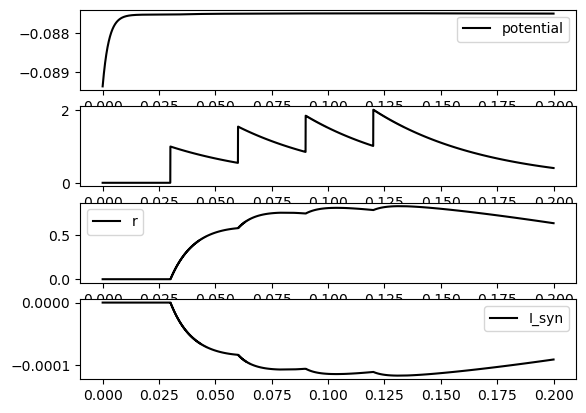

In [19]:
device.reinit()
device.activate()

#-----------------------------------------------------------------------------------------------------------------------
# Default Imports
#-----------------------------------------------------------------------------------------------------------------------
import numpy as np
import scipy.constants as spc

from Equations_calc import calculate_gating_variable_n, calculate_gating_variable_h, calculate_gating_variable_m, return_HH_equations, return_plotting_list
from Equations import calc_leakage_conductance, I_Na_inf, f_NaK, sigma, calculate_I_NKP_max

#-----------------------------------------------------------------------------------------------------------------------
# Brian2 import: we use Brian CPP-standalone code generation for fast parallelized simulations
#-----------------------------------------------------------------------------------------------------------------------
from brian2 import *
code_dir = './codegen'
prefs.GSL.directory = '/opt/anaconda3/envs/Brian2_NGILab/include/'   ## The directory where the GSL library headings are found
set_device('cpp_standalone',directory=code_dir,build_on_run=False)
prefs.devices.cpp_standalone.openmp_threads = 2 ## The number of threads used in the parallelization (machine-dependent)
prefs.logging.file_log = False
prefs.logging.delete_log_on_exit = True

import matplotlib.pyplot as plt

#-----------------------------------------------------------------------------------------------------------------------
## Utilities
#-----------------------------------------------------------------------------------------------------------------------
def varargin(pars, **kwargs):
    """
    varargin-like option for user-defined parameters in any function/module
    Use:
    pars = varargin(pars,**kwargs)

    Input:
    - pars     : the dictionary of parameters of the calling function
    - **kwargs : a dictionary of user-defined parameters

    Output:
    - pars     : modified dictionary of parameters to be used inside the calling
                 (parent) function

    Maurizio De Pitta', The University of Chicago, August 27th, 2014.
    """
    for key, val in kwargs.items():
        if key in pars:
            pars[key] = val
    return pars

#-----------------------------------------------------------------------------------------------------------------------
## Build User-defined convenience functions to be also called by equations in neuron models by Brian
#-----------------------------------------------------------------------------------------------------------------------
def Hill(x,K,n):
    return x**n/(x**n+K**n)
Hill = Function(Hill,arg_units=[mmolar,mmolar,1], return_unit=1,auto_vectorise=False)
Hill_cpp = '''
    #include <math.h>
    double Hill(double x,double K,double n)
    {
        return pow(x,n)/(pow(x,n)+pow(K,n));
    };
    '''
Hill.implementations.add_implementation('cpp',Hill_cpp,compiler_kwds={'headers': ['"math.h"']})

def ThermalVoltage(T):
    return spc.R*(T+273.15)/spc.physical_constants['Faraday constant'][0]
ThermalPotential = Function(ThermalVoltage,arg_units=[1], return_unit=1,auto_vectorise=False)
ThermalVoltage_cpp = '''
    #include <gsl/gsl_const_mksa.h>
    double ThermalPotential(const double T)
    {
        const double R = GSL_CONST_MKSA_MOLAR_GAS;
        const double F = GSL_CONST_MKSA_FARADAY;
        return R*(T+273.15)/F;
    }
    '''
ThermalPotential.implementations.add_implementation('cpp',ThermalVoltage_cpp,
                                                  compiler_kwds={'headers': ['"gsl_const_mksa.h"'],
                                                                 'include_dirs': ['/opt/anaconda3/envs/Brian2_NGILab/include/']})
def NernstPotential(x_e,x_i,z,T):
    """
    Nernst potential in volts (w/out units)

    Input parameters (w/out units):
    - x_e : float   Intracellular concentration
    - x_i : float   Extracellyular concentration
    - z   : int     Ion valence
    - T   : float   Temperature in ^C

    Return:
    - E_x : Nernst Reverse Potential in volt (W/OUT units)
    """
    V_T = ThermalVoltage(T)
    return V_T/z*np.log(x_e/x_i)
NernstPotential = Function(NernstPotential,arg_units=[mmolar,mmolar,1,1], return_unit=1,auto_vectorise=False)
NernstPotential_cpp = '''
    #include <gsl/gsl_const_mksa.h>
    const double R = GSL_CONST_MKSA_MOLAR_GAS; 
    const double F = GSL_CONST_MKSA_FARADAY;
    double ThermalVoltage(const double T)
    {
        return R*(T+273.15)/F;
    };
    double NernstPotential(double x_e,double x_i,double z,const double T)
    {
        return ThermalVoltage(T)*log(x_e/x_i)/z;
    };
    '''
NernstPotential.implementations.add_implementation('cpp',NernstPotential_cpp,
                                                   dependencies={'log': DEFAULT_FUNCTIONS['log']},
                                                   compiler_kwds={'headers': ['"gsl_const_mksa.h"'],
                                                                  'include_dirs': ['/opt/anaconda3/envs/Brian2_NGILab/include/']})


def Heaviside_Function(t_step, t_end, t):
    if (t < t_step):
        return 0
    elif (t_step <= t <= t_end):
        return 1
    else:
        return 0
Heaviside_Function = Function(Heaviside_Function,arg_units=[second,second,second], return_unit=1,auto_vectorise=False)
Heaviside_Function_cpp = '''
    double Heaviside_Function(double t_step, double t_end, double t)
    {
    if (t < t_step)
        return 0;
    else if (t <= t_end)
        return 1;
    else
        return 0;
    };
    '''
Heaviside_Function.implementations.add_implementation('cpp',Heaviside_Function_cpp,
                                                   dependencies={'log': DEFAULT_FUNCTIONS['log']},
                                                    )

def lpc5_parameters(model='hh-neuron',**kwargs):
    """
    Method to generate neuron parameters' dictionary.

    Input parameters:
    - model  : {'hh-neuron'} (or 'hh') | 'hh-ecs'   Model equations
    **kwargs : list of custom parameters specified by <parameter name>=<value in units>

    Return:
    - pars   : dict
    """

    ta = TimedArray([0, 0, 1, 0] * 1, dt=0.05*second)

    # Define dictionary of default parameters values
    pars = {## Concentrations to setup reverse potentials
            'N0_i': 10*mmolar,
            'N0_e': 145*mmolar,
            'K0_i': 130*mmolar,
            'K0_e': 3*mmolar,
            'C0_i': 5*mmolar,
            'C0_e': 130*mmolar,
            ## Neuron Parameters and conductances
            'c_m' : 1*ufarad/cm**2,
            'g_Na': 2.04e6*usiemens/cm**2,
            'g_K' : 0.638e6*usiemens/cm**2,
            'g_Cl': 0.338e3*usiemens/cm**2,
            'v_thr' : 0*mvolt,
            ## Gating variables
            'U_m' : -38*mvolt,
            'U_h' : -66*mvolt,
            'U_n' : 18.7*mvolt,
            'W_m' : 6*mvolt,
            'W_h' : 6*mvolt,
            'W_n' : 9.7*mvolt,
            ## Temperature
            'T_exp' : 37, ## Body temperature of the animal
            ## External Stimulation
            'I_dc'  : 0*namp/cm**2,
            'I_ramp': 0*namp/cm**2,
            'I_max' : 0*namp/cm**2,
            'T_ramp': 100*second,
            'TimedArray': ta,
            ## times
            't_step': 0.05 * second,
            't_end' : 0.1 * second,
            ## Synapse reversal potential
            'E_syn': 50*mvolt
            }

    pars = varargin(pars,**kwargs)

    # We define this quantities after any user-defined parameters are specified
    pars['T_adj'] = 2.3**(0.1*(pars['T_exp']-21))
    pars['E_Na'] = NernstPotential(pars['N0_e'],pars['N0_i'],1,pars['T_exp'])*volt
    pars['E_K']  = NernstPotential(pars['K0_e'],pars['K0_i'],1,pars['T_exp'])*volt
    pars['E_Cl'] = NernstPotential(pars['C0_e'],pars['C0_i'],-1,pars['T_exp'])*volt

    ## Physics constants
    pars['F'] = spc.physical_constants['Faraday constant'][0]*coulomb/mole

    pars['V_T'] = ThermalVoltage(37) * volt

    return pars

def lpc5_neuron(N,params,model='hh-neuron',name='hh*',dt=None):
    """
    Method that generate the "neuron" model with given parameters.

    Input aarguments:
    - N      : int      Number of neurons to simulate
    - params : dict     Dictionary of neuron parameters
    - model  : {'hh-neuron'} | 'hh-ecs'  Model equations
    - name   : String   The name assigned to the NeuronGroup
    - dt     : float*second minimum time step for numerical integration

    Return:
    - neuron : NeuronGroup
    """
    # I_inj=I_dc+I_ramp*t/T_ramp                      : amp/meter**2
    # I_inj= 2*I_max-(I_max*exp((t-(0.15*second))**2/(2*0.003*(second**2))))                     : amp/meter**2

    eqs = Equations('''
    a_m=-0.182/second/mvolt*(v-U_m)/expm1((U_m-v)/W_m)   : hertz
    b_m=-0.124/second/mvolt*(U_m-v)/expm1((v-U_m)/W_m)   : hertz
    a_h=-0.015/second/mvolt*(U_h-v)/expm1((v-U_h)/W_h)   : hertz
    b_h=-0.015/second/mvolt*(v-U_h)/expm1((U_h-v)/W_h)   : hertz
    m_inf=a_m/(a_m+b_m)                                : 1
    h_inf=a_h/(a_h+b_h)                                : 1
    n_inf=1/(1+exp(-(v-U_n)/W_n))                      : 1
    tau_m=1e-3/(a_m+b_m)/T_adj                         : second
    tau_h=1e-3/(a_h+b_h)/T_adj                         : second
    tau_n=4*ms/(1+exp(-(v+56.56*mvolt)/(44.14*mvolt)))/T_adj      : second
    I_inj=I_max * TimedArray(t)                    : amp/meter**2
    dm/dt=(m_inf-m)/tau_m                           : 1
    dh/dt=(h_inf-h)/tau_h                           : 1
    dn/dt=(n_inf-n)/tau_n                           : 1
    ''')

    if model == 'hh-neuron':
        eqs += Equations('''
            I_Na=g_Na*m**3*h*(v-E_Na)                       : amp/meter**2
            I_K=g_K*n*(v-E_K)                               : amp/meter**2
            I_Cl_L=g_Cl*(v-E_Cl)                              : amp/meter**2
            dv/dt=(I_inj-I_Na-I_K-I_Cl_L)/c_m                 : volt   
        ''')

    elif model == 'hh-neuron-synapse':
        eqs += Equations('''
            I_Na=g_Na*m**3*h*(v-E_Na)                       : amp/meter**2
            I_K=g_K*n*(v-E_K)                               : amp/meter**2
            I_Cl_L=g_Cl*(v-E_Cl)                            : amp/meter**2
            dv/dt=(I_inj-I_Na-I_K-I_Cl_L-I_syn)/c_m         : volt   
            g_syn                               : siemens/meter**2
            E_syn = E_Cl : volt
            I_syn = g_syn*(v - E_syn)                       : amp/meter**2
        ''')
        ## E_syn has to be E_AMPA (E_syn = V_T * log((N0_e + 1.2*K0_e)/(N0_i + 1.2 * K0_i)) : volt) for excitatory synapse and E_GABA () for inhibitory synapse
    else:
        ## w/ ECS
        pass

    neuron = NeuronGroup(N,eqs,
                         threshold='v>v_thr',
                         namespace=params,
                         name=name,
                         method='rk4',
                         dt=dt)

    # Initialize gating variables
    neuron.m = calculate_gating_variable_m(-89.36394687557272)
    neuron.h = calculate_gating_variable_h(-89.36394687557272)
    neuron.n = calculate_gating_variable_n(-89.36394687557272)

    return neuron

def dummy_neuron():
    input_neuron = NeuronGroup(1, 'dx/dt = 0 : 1')
    return input_neuron


def single_synapse(input_signal, neurons_2): 
    ## TimedArray
    # time_points = arange(0, 0.2 * second, defaultclock.dt)
    # s_values = np.zeros(len(time_points))
    # s_values[(time_points >= 5*ms) & (time_points < 10*ms)] = 1.0
    
    ## synapse params
    Synapse_pars = {
        'E_syn' : 50 * mvolt,
        'tau_r_x' : 50*ms,
        'tau_x' : 50*ms,
        'J' : 1,
        'g_s' : 35*usiemens/cm**2,
        'W' : 3
        #'c_m': 1*ufarad/cm**2,
        #'weight': 60*mvolt,
        #'neuron_firing' : TimedArray(s_values, dt=defaultclock.dt) 
    }
    
    
    synapse_eqs = ''' 
    g_syn_post = g_s * r  : siemens/meter ** 2 (summed)
    dr/dt = (-r + x_syn * W * (1 - r))/tau_r_x   : 1
    dx_syn/dt = (-x_syn)/tau_x       : 1
    '''
    synapse_action = '''
    x_syn += J
    '''
    S = Synapses(input_signal, neurons_2, model=synapse_eqs, on_pre=synapse_action, namespace=Synapse_pars)
    S.connect()
    S.r = 0
    S.x_syn = 0

    return S

    ## initial conditions
    ## COMMENTS FOR FURTHER POGRESS:
    ## 1. Don't forget to add membrane capacitance in I_syn/ dv/dt in output neuron
    ## 2. Simulate spiking behavior in current via TimedArray or Poisson distribution


def lpc5_simulation(duration=0.2,model='hh-neuron-synapse',**kwargs):
    """
    This is the actual simulation of the Neuron. It is provided as a standalone method for modularity.

    Input parameters:
    - duration   : float*second   Simulated Time
    - model      : {'hh-neuron'} | 'hh-ecs'   Use only 'hh-neuron' for now. Other cases will be added later.
    :param kwargs:
    :return:
    """

    device.delete(force=True)
    ## Build the neuron model and monitors
    params = lpc5_parameters(model=model,T_ramp=duration*second,**kwargs)

    # Initialize first neuron
    cell = lpc5_neuron(1,params,model=model,name='HH',dt=0.1*us)
    ## CONNECT TO EQUATIONS LATERON TO HAND cell.v the correct value
    cell.v = -89.36394687557272 * mvolt
    E_syn = params['V_T'] * log((params['N0_e'] + 1.2* params['K0_e'])/(params['N0_i'] + 1.2 * params['K0_i']))
    print(f'E_syn {E_syn}')

    # Initialize second neuron
    indices = array([0, 0, 0, 0])
    times = array([30, 60, 90, 120])*ms
    G = SpikeGeneratorGroup(1, indices, times)

    P = PoissonGroup(1, np.arange(1)*Hz + 100*Hz)
    
    # input_neuron = dummy_neuron() 

    # Initialize Synapse
    synapse = single_synapse(G, cell)

    # Set monitors
    if model=='hh-neuron-synapse':
        variables = ['v', 'I_syn']
    elif model=='hh-ecs':
        variables = ['v','C_i','N_i','K_i','I_K','I_Na','I_Cl','n_Cl','n_K','E_Cl']
    synapse_monitor = StateMonitor(synapse, variables=['r', 'x_syn'],record = [0], dt=0.01*ms, name='synapsemon')
    sv_mon = StateMonitor(cell,variables=variables,record=True,dt=0.01*ms,name='svmon')
    # Gene
    network = Network([cell, G, synapse, sv_mon, synapse_monitor])
    ## Run the simulator
    network.run(duration=duration*second,report='text')
    device.build(directory=code_dir, clean=True)

    ## Visualizing data
    if model=='hh-neuron-synapse':
        fig, ax = plt.subplots(4, 1)
        ax[0].plot(sv_mon.t, sv_mon.v[:].T, 'k-', label = 'potential')
        ax[0].legend()
        ax[1].plot(synapse_monitor.t, synapse_monitor.x_syn[:].T, 'k-')
        ax[2].plot(synapse_monitor.t, synapse_monitor.r[:].T, 'k-', label = 'r')
        ax[2].legend()
        ax[3].plot(synapse_monitor.t, sv_mon.I_syn[:].T, 'k-', label = 'I_syn')
        ax[3].legend()
    
            
        
    elif model=='hh-ecs':
        fig, ax = plt.subplots(6, 1,sharex=True)
        ax[0].plot(sv_mon.t, sv_mon.v[:].T, 'k-')
        ax[0].plot(sv_mon.t, sv_mon.E_Cl[:].T, 'm-')
        # ax[1].plot(sv_mon.t, sv_mon.C_i[:].T, 'm-')
        # ax[1].plot(sv_mon.t, sv_mon.C_i[:].T, 'r-')
        # ax[1].plot(sv_mon.t, sv_mon.N_i[:].T, 'r-')
        # ax[1].plot(sv_mon.t,sv_mon.I_Na[:].T,'r-')
        # ax[2].plot(sv_mon.t,sv_mon.I_K[:].T,'b-')
        # ax[3].plot(sv_mon.t,sv_mon.I_Cl[:].T,'g-')
        # ax[4].plot(sv_mon.t,sv_mon.I_NKP[:].T,'y-')
        # ax[5].plot(sv_mon.t,sv_mon.I_KCC[:].T,'m-')
        ax[1].plot(sv_mon.t, sv_mon.n_Cl[:].T, 'm-')
        ax[1].hlines(0,*sv_mon.t[[0,-1]])
        ax[2].plot(sv_mon.t, sv_mon.I_Cl[:].T, 'r-')
        ax[3].plot(sv_mon.t, sv_mon.n_K[:].T, 'g-')

    device.delete(force=True)

if __name__=="__main__":
    """
    Uncomment individual sections to test different methods 
    """

    # #-------------------------------------------------------------------------------------------------------------------
    # # Verify Reverse Potentials
    # #-------------------------------------------------------------------------------------------------------------------
    # T= 37
    # print('E_Na\t',NernstPotential(126,9,1,T))
    # print('E_K\t',NernstPotential(2.5,130,1,T))
    # print('E_Cl\t',NernstPotential(130,10,-1,T))

    # #-------------------------------------------------------------------------------------------------------------------
    # # Generate Neuron Simulation
    # #-------------------------------------------------------------------------------------------------------------------
    print(lpc5_parameters('hh-neuron',I_dc=10**4.5*nA/cm**2))
    # Single Neuron
    lpc5_simulation(duration=0.2,model='hh-neuron-synapse',I_dc=0**4.2*nA/cm**2)

    # #-------------------------------------------------------------------------------------------------------------------
    ## Show figures
    # #-------------------------------------------------------------------------------------------------------------------
    plt.show()